In [4]:
import random

import torch
import torch.nn as nn
from cmws import util
import torch
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams,
    softmax_rgb_blend
)
from pytorch3d.structures.meshes import (
    Meshes,
    join_meshes_as_batch,
    join_meshes_as_scene,
)
import numpy as np
from cmws.examples.stacking_3d import data, render
from cmws import util
import matplotlib.pyplot as plt
import os

device = 'cpu'

In [12]:
exp_pth = "/om/user/katiemc/continuous_mws/save/rws_updated_learn_blur/"
rec_pth = f'{exp_pth}rws_1/reconstructions'
rec_pth

'/om/user/katiemc/continuous_mws/save/rws_updated_learn_blur/rws_1/reconstructions'

In [17]:
imgs = os.listdir(rec_pth)
sorted(imgs)

['10001.png',
 '1001.png',
 '10011.png',
 '10021.png',
 '10031.png',
 '10041.png',
 '10051.png',
 '10061.png',
 '10071.png',
 '10081.png',
 '10091.png',
 '10101.png',
 '1011.png',
 '10111.png',
 '10121.png',
 '10131.png',
 '10141.png',
 '10151.png',
 '10161.png',
 '10171.png',
 '10181.png',
 '10191.png',
 '10201.png',
 '1021.png',
 '10211.png',
 '10221.png',
 '10231.png',
 '10241.png',
 '10251.png',
 '10261.png',
 '10271.png',
 '10281.png',
 '10291.png',
 '10301.png',
 '1031.png',
 '10311.png',
 '10321.png',
 '10331.png',
 '10341.png',
 '10351.png',
 '10361.png',
 '10371.png',
 '10381.png',
 '10391.png',
 '10401.png',
 '1041.png',
 '10411.png',
 '10421.png',
 '10431.png',
 '10441.png',
 '10451.png',
 '10461.png',
 '10471.png',
 '10481.png',
 '10491.png',
 '10501.png',
 '1051.png',
 '10511.png',
 '10521.png',
 '10531.png',
 '10541.png',
 '10551.png',
 '10561.png',
 '10571.png',
 '10581.png',
 '10591.png',
 '10601.png',
 '1061.png',
 '10611.png',
 '10621.png',
 '10631.png',
 '10641.png',

In [22]:
img_idx_map = {int(img_pth.split('.png')[0]):img_pth for img_pth in imgs}
img_idxs = sorted(list(img_idx_map.keys()))

In [23]:
util.make_gif([f'{rec_pth}/{img_idx_map[img_idx]}' for img_idx in img_idxs], 'rws_learn_blur.gif', fps=50)

100%|██████████| 1348/1348 [01:26<00:00, 15.62it/s]


12:59:11 | /om/user/katiemc/continuous_mws/cmws/util.py:194 | INFO: Saved to rws_learn_blur.gif


In [42]:
num_primitives = 3
primitives = [
    render.Cube(
        "A", torch.tensor([1.0, 0.0, 0.0], device=device), torch.tensor(0.3, device=device)
    ),
    render.Cube(
        "B", torch.tensor([0.0, 1.0, 0.0], device=device), torch.tensor(0.4, device=device)
    ),
    render.Cube(
        "C", torch.tensor([0.0, 0.0, 1.0], device=device), torch.tensor(0.5, device=device)
    ),
][:num_primitives]
# num_primitives = len(primitives)

# Sample
stacking_program = data.sample_stacking_program(
    num_primitives, device, fixed_num_blocks=False
)
raw_locations = data.sample_raw_locations(stacking_program)

In [43]:
im_size = 32

shape = stacking_program.shape[:-1]
max_num_blocks = stacking_program.shape[-1]
num_elements = util.get_num_elements(shape)
num_channels = 3
num_blocks = torch.tensor(len(stacking_program), device=device).long()

# [num_primitives]
square_size = torch.stack([primitive.size for primitive in primitives])
# [num_primitives, 3]
square_color = torch.stack([primitive.color for primitive in primitives])

# Convert [*shape, max_num_blocks, 3]
locations = render.convert_raw_locations_batched(raw_locations, stacking_program, primitives)

# Flatten
num_blocks_flattened = num_blocks.reshape(num_elements)
stacking_program_flattened = stacking_program.reshape((num_elements, max_num_blocks))
locations_flattened = locations.view((num_elements, max_num_blocks, 3))

imgs = render.render_cubes(num_blocks_flattened, square_size[stacking_program_flattened], square_color[stacking_program_flattened], locations_flattened, im_size)
imgs = imgs.permute(0, 3, 1, 2)
imgs = imgs.view(*[*shape, num_channels, *imgs.shape[-2:]])

In [44]:
num_cubes = num_blocks_flattened
sizes = square_size[stacking_program_flattened]
colors = square_color[stacking_program_flattened]
positions = locations_flattened

In [45]:

im_size = 512

# Create camera
R, T = look_at_view_transform(1.0, 90, 180,
                              up=((0.0, -1.0, 0.0),),
                              at=((0.0, 1, -0.2),))  # view top to see stacking
cameras = FoVPerspectiveCameras(device=device, R=R, T=T,
                               fov=60.0)

# Settings for rasterizer (optional blur)
# 
# blend_params = BlendParams( sigma = 1e-4, gamma = 1e-4,background_color=(0.0,0.0,0.0))
blend_params = BlendParams( sigma = torch.abs(torch.randn(())*1e-2), gamma = torch.abs(torch.randn(())*1e-2),background_color=(0.0,0.0,0.0))
raster_settings = RasterizationSettings(
    image_size=im_size, # crisper objects + texture w/ higher resolution
    blur_radius = np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=3, # increase at cost of GPU memory,
    bin_size=0
)

# Add light from the front
lights = PointLights(device=device, location=[[0.0, 3.0, 0.0]]) # top light

# Compose renderer and shader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights,
        blend_params=blend_params
    )
)

# create one mesh per elmt in batch

meshes = []
for batch_idx, n_cubes in enumerate(num_cubes):
    # Combine obj meshes into single mesh from rendering
    # https://github.com/facebookresearch/pytorch3d/issues/15
    vertices = []
    faces = []
    textures = []
    vert_offset = 0 # offset by vertices from prior meshes
    for i, (position, size,color) in enumerate(zip(positions[batch_idx, :n_cubes, :], sizes[batch_idx, :n_cubes],
                                                   colors[batch_idx, :n_cubes, :])):
        cube_vertices, cube_faces = render.get_cube_mesh(position, size)
        # For now, apply same color to each mesh vertex (v \in V)
        texture = torch.ones_like(cube_vertices) * color# [V, 3]
        # Offset faces (account for diff indexing, b/c treating as one mesh)
        cube_faces = cube_faces + vert_offset
        vert_offset = cube_vertices.shape[0]
#         if i == 1: cube_vertices[:, 2] += 0.05
        vertices.append(cube_vertices)
        faces.append(cube_faces)
        textures.append(texture)

    # Concatenate data into single mesh
    vertices = torch.cat(vertices)
    faces = torch.cat(faces)
    textures = torch.cat(textures)[None]  # (1, num_verts, 3)
    textures = TexturesVertex(verts_features=textures)
    # each elmt of verts array is diff mesh in batch
    mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)
    meshes.append(mesh)

batched_mesh = join_meshes_as_batch(meshes)

# Render image
img = renderer(batched_mesh)   # (B, H, W, 4)

# Remove alpha channel and return (B, im_size, im_size, 3)
img = img[:, ..., :3]#.detach().squeeze().cpu().numpy()

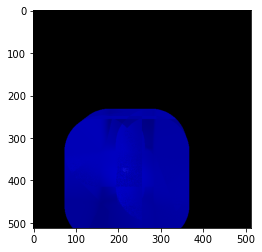

In [46]:
plt.imshow(img[0])
#plt.axis('off')

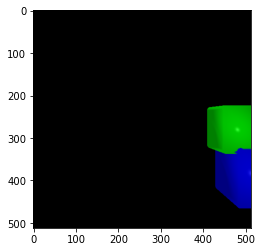

In [314]:
plt.imshow(img[0])
#plt.axis('off')

In [175]:
np.log(1.0 / 1e-4 - 1.0) * 1e-5

9.21024036697585e-05

In [37]:
cube_vertices[:, 1] += 0.5

In [36]:
cube_vertices2 = cube_vertices

In [20]:
blend_params = BlendParams(sigma=torch.randn(()), gamma=1e-4)

In [7]:
torch.randn(())

tensor(-0.3075)

In [8]:
torch.randn(())

tensor(1.0164)

In [9]:
torch.randn(())

tensor(-0.4894)

In [10]:
torch.randn(())

tensor(0.2492)

In [2]:
sigma = torch.randn(())
gamma = torch.randn(())
print(sigma, gamma)

tensor(0.1161) tensor(-0.6644)


In [29]:
sigma * 1e-2

tensor(-0.0025)

In [37]:
blend_params

BlendParams(sigma=tensor(-0.0001), gamma=tensor(2.4272e-06), background_color=(0.0, 0.0, 0.0))

In [3]:
torch.Tensor(0.1161)

TypeError: new(): data must be a sequence (got float)

In [5]:
sigma.dtype

torch.float32

In [10]:
1.8313 * 1e-3

0.0018313